# Finetuning FakeNewsAAAI Zero Shot Yejin
FakeNewsAAAI is a Fake News dataset with 2 possible labels: `real` and `fake`

In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import random
import numpy as np
import pandas as pd
import torch
from torch import optim
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from tqdm import tqdm
import pickle
from copy import deepcopy
from multiprocessing import Pool                                                

from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer
from utils.forward_fn import forward_mask_sequence_classification
from utils.metrics import classification_metrics_fn
from utils.data_utils import FakeNewsDataset, FakeNewsDataLoader
from utils.utils import generate_random_mask

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.4f}'.format(key, value))
    return ' '.join(string_list)

In [4]:
def influence_score(model, id, subword, mask, label, device='cpu'):
    loss_fct = CrossEntropyLoss(reduction='none')
    with torch.no_grad():
        # Prepare input & label
        subword = torch.LongTensor(subword)
        mask = torch.FloatTensor(mask)
        label = torch.LongTensor(label)

        if device == "cuda":
            subword = subword.cuda()
            mask = mask.cuda()
            label = label.cuda()

        if isinstance(model, BertForSequenceClassification):
            # Apply mask
            weight, bias = model.classifier.weight, model.classifier.bias
            dropout_mask = generate_random_mask([id], weight.shape[0], weight.shape[1], device=device).repeat(subword.shape[0],1,1)
            masked_weight = weight.expand_as(dropout_mask) * dropout_mask

            # Calculate latents
            latents = model.bert(subword, attention_mask=mask)[1]
            latents = model.dropout(latents)            
        elif isinstance(model, RobertaForSequenceClassification):
            # Apply mask
            weight, bias = model.classifier.out_proj.weight, model.classifier.out_proj.bias
            dropout_mask = generate_random_mask([id], weight.shape[0], weight.shape[1], device=device).repeat(subword.shape[0],1,1)
            masked_weight = weight.expand_as(dropout_mask) * dropout_mask

            # Calculate latents
            latents = model.roberta(subword, attention_mask=mask)[0][:,0,:]
            latents = model.classifier.dense(latents)
            latents = model.classifier.dropout(latents)
        else:
            raise ValueError(f'Model class `{type(model)}` is not implemented yet')

        # Compute loss with mask
        logits = torch.einsum('bd,bcd->bc', latents, masked_weight) + bias
        mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))

        # Compute loss with flipped mask
        logits = torch.einsum('bd,bcd->bc', latents, (masked_weight.max() - masked_weight)) + bias
        flipped_mask_loss = loss_fct(logits.view(-1, model.num_labels), label.view(-1))
                              
        return flipped_mask_loss - mask_loss
                              
def build_influence_matrix(model, data_loader, train_size, device='cpu'):
    test_size, batch_size = len(data_loader.dataset), data_loader.batch_size
    influence_mat = torch.zeros(test_size, train_size, device=device)
    for i, batch_data in enumerate(data_loader):
        print(f'Processing batch {i+1}/{len(data_loader)}')
        (ids, subword_batch, mask_batch, label_batch, seq_list) = batch_data
        token_type_batch = None

        for train_idx in tqdm(range(train_size)):
            train_id = train_idx + 1
            scores = influence_score(model, train_id, subword_batch, mask_batch, label_batch, device=device)
            for j, id in enumerate(ids):
                influence_mat[(i * batch_size) + j, train_idx] = scores[j]
    return influence_mat

def get_inference_result(model, data_loader, device='cpu'):
    results = {}
    with torch.no_grad():
        pbar = tqdm(data_loader, leave=True, total=len(data_loader))
        for i, batch_data in enumerate(pbar):
            batch_id = batch_data[0]
            batch_seq = batch_data[-1]
            outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
            loss, batch_hyp, batch_label, logits, label_batch = outputs

            for i, id in enumerate(batch_id):
                results[id] = batch_hyp[i] == batch_label[i]
    return results

def get_filtered_dataloader(data_loader, id_list, inclusive=True, batch_size=2, shuffle=False):
    df = data_loader.dataset.data
    if inclusive:
        filt_df = df.loc[df['id'].isin(id_list),:].reset_index(drop=True)
    else:
        filt_df = df.loc[~df['id'].isin(id_list),:].reset_index(drop=True)
    dataset = FakeNewsDataset(dataset_path=None, dataset=filt_df, tokenizer=tokenizer, lowercase=False)
    data_loader = FakeNewsDataLoader(dataset=dataset, max_seq_len=512, batch_size=batch_size, num_workers=2, shuffle=shuffle)  
    return data_loader

In [5]:
# Set random seed
set_seed(26092020)

# Load Model

In [6]:
# Load Tokenizer and Config
tokenizer = AutoTokenizer.from_pretrained('roberta-large')
config = AutoConfig.from_pretrained('roberta-large')
config.num_labels = FakeNewsDataset.NUM_LABELS

# Instantiate model
model = AutoModelForSequenceClassification.from_pretrained('roberta-large', config=config)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [7]:
count_param(model)

355361794

# Prepare Dataset

In [8]:
train_dataset_path = './data/train.tsv'
valid_dataset_path = './data/valid.tsv'
valid_zero_dataset_path = './data/covid19_infodemic_english_data/processed_valid_data.tsv'

In [9]:
train_dataset = FakeNewsDataset(dataset_path=train_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_dataset = FakeNewsDataset(dataset_path=valid_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_zero_dataset = FakeNewsDataset(dataset_path=valid_zero_dataset_path, tokenizer=tokenizer, lowercase=False)

train_loader = FakeNewsDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=2, num_workers=2, shuffle=True)  
valid_loader = FakeNewsDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=2, num_workers=2, shuffle=False)  
valid_zero_loader = FakeNewsDataLoader(dataset=valid_zero_dataset, max_seq_len=512, batch_size=2, num_workers=2, shuffle=False)

In [10]:
w2i, i2w = FakeNewsDataset.LABEL2INDEX, FakeNewsDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'fake': 0, 'real': 1}
{0: 'fake', 1: 'real'}


In [11]:
len(train_dataset), len(valid_dataset), len(valid_zero_dataset)

(6420, 2140, 60)

# Fine Tuning & Evaluation

In [11]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [12]:
# Train without mask
n_epochs = 10
best_val_metric, best_metrics, best_state_dict = 0, None, None
early_stop, count_stop = 3, 0
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=False, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=False, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = classification_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Early stopping
    val_metric = metrics['F1']
    if best_val_metric <= val_metric:
        torch.save(model.state_dict(), './tmp_yejin/model_wo_mask_weight.pt')
        best_val_metric = val_metric
        best_metrics = metrics
        count_stop = 0
    else:
        count_stop += 1
        if count_stop == early_stop:
            break
            
print('== BEST METRICS ==')
print(metrics_to_string(best_metrics))

(Epoch 1) TRAIN LOSS:0.1606 LR:0.00000300: 100%|██████████| 3210/3210 [09:15<00:00,  5.77it/s]
/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.1606 ACC:0.9366 F1:0.9364 REC:0.9361 PRE:0.9368 LR:0.00000300


VALID LOSS:0.0673 ACC:0.9739 F1:0.9738 REC:0.9746 PRE:0.9733:  80%|████████  | 860/1070 [00:33<00:08, 24.82it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0699 ACC:0.9743 F1:0.9743 REC:0.9747 PRE:0.9740: 100%|██████████| 1070/1070 [00:42<00:00, 25.22it/s]


(Epoch 1) VALID LOSS:0.0699 ACC:0.9743 F1:0.9743 REC:0.9747 PRE:0.9740


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0532 ACC:0.9807 F1:0.9806 REC:0.9806 PRE:0.9807 LR:0.00000300


/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0782 ACC:0.9704 F1:0.9703 REC:0.9712 PRE:0.9698:  81%|████████  | 862/1070 [00:34<00:09, 21.79it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0825 ACC:0.9706 F1:0.9705 REC:0.9710 PRE:0.9703: 100%|██████████| 1070/1070 [00:44<00:00, 24.05it/s]
  0%|          | 0/3210 [00:00<?, ?it/s]

(Epoch 2) VALID LOSS:0.0825 ACC:0.9706 F1:0.9705 REC:0.9710 PRE:0.9703


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0293 ACC:0.9896 F1:0.9895 REC:0.9895 PRE:0.9896 LR:0.00000300


VALID LOSS:0.0674 ACC:0.9762 F1:0.9761 REC:0.9770 PRE:0.9756:  81%|████████  | 862/1070 [00:36<00:10, 19.37it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0688 ACC:0.9757 F1:0.9757 REC:0.9760 PRE:0.9754: 100%|██████████| 1070/1070 [00:47<00:00, 22.56it/s]


(Epoch 3) VALID LOSS:0.0688 ACC:0.9757 F1:0.9757 REC:0.9760 PRE:0.9754


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0211 ACC:0.9933 F1:0.9933 REC:0.9933 PRE:0.9933 LR:0.00000300


VALID LOSS:0.0597 ACC:0.9820 F1:0.9819 REC:0.9819 PRE:0.9820:  80%|████████  | 860/1070 [00:34<00:09, 21.86it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0658 ACC:0.9804 F1:0.9803 REC:0.9802 PRE:0.9805: 100%|██████████| 1070/1070 [00:43<00:00, 24.37it/s]


(Epoch 4) VALID LOSS:0.0658 ACC:0.9804 F1:0.9803 REC:0.9802 PRE:0.9805


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0164 ACC:0.9947 F1:0.9947 REC:0.9947 PRE:0.9947 LR:0.00000300


VALID LOSS:0.0767 ACC:0.9797 F1:0.9796 REC:0.9800 PRE:0.9793:  81%|████████  | 862/1070 [00:33<00:09, 22.60it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0910 ACC:0.9776 F1:0.9775 REC:0.9777 PRE:0.9774: 100%|██████████| 1070/1070 [00:43<00:00, 24.76it/s]
  0%|          | 0/3210 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.0910 ACC:0.9776 F1:0.9775 REC:0.9777 PRE:0.9774


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0130 ACC:0.9960 F1:0.9959 REC:0.9960 PRE:0.9959 LR:0.00000300


VALID LOSS:0.0861 ACC:0.9803 F1:0.9802 REC:0.9798 PRE:0.9805:  80%|████████  | 860/1070 [00:33<00:10, 20.58it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0909 ACC:0.9780 F1:0.9780 REC:0.9777 PRE:0.9783: 100%|██████████| 1070/1070 [00:43<00:00, 24.46it/s]
  0%|          | 0/3210 [00:00<?, ?it/s]

(Epoch 6) VALID LOSS:0.0909 ACC:0.9780 F1:0.9780 REC:0.9777 PRE:0.9783


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 7) TRAIN LOSS:0.0130 ACC:0.9955 F1:0.9955 REC:0.9955 PRE:0.9955 LR:0.00000300


VALID LOSS:0.0973 ACC:0.9751 F1:0.9749 REC:0.9741 PRE:0.9759:  81%|████████  | 862/1070 [00:35<00:09, 22.41it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1024 ACC:0.9743 F1:0.9742 REC:0.9737 PRE:0.9750: 100%|██████████| 1070/1070 [00:45<00:00, 23.77it/s]

(Epoch 7) VALID LOSS:0.1024 ACC:0.9743 F1:0.9742 REC:0.9737 PRE:0.9750
== BEST METRICS ==
ACC:0.9804 F1:0.9803 REC:0.9802 PRE:0.9805


In [12]:
# Load Tokenizer and Config
tokenizer = AutoTokenizer.from_pretrained('roberta-large')
config = AutoConfig.from_pretrained('roberta-large')
config.num_labels = FakeNewsDataset.NUM_LABELS

# Instantiate model
model = AutoModelForSequenceClassification.from_pretrained('roberta-large', config=config)

optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [13]:
# Train with mask
n_epochs = 10
best_val_metric, best_metrics, best_state_dict = 0, None, None
early_stop, count_stop = 3, 0
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        outputs = forward_mask_sequence_classification(model, batch_data[:-1], i2w=i2w, apply_mask=True, device='cuda')
        loss, batch_hyp, batch_label, logits, label_batch = outputs
        
        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = classification_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = classification_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # Early stopping
    val_metric = metrics['F1']
    if best_val_metric <= val_metric:
        torch.save(model.state_dict(), './tmp_yejin/model_weight.pt')
        best_val_metric = val_metric
        best_metrics = metrics
        count_stop = 0
    else:
        count_stop += 1
        if count_stop == early_stop:
            break
            
print('== BEST METRICS ==')
print(metrics_to_string(best_metrics))

(Epoch 1) TRAIN LOSS:0.1977 LR:0.00000300: 100%|██████████| 3210/3210 [09:09<00:00,  5.84it/s]
/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'fake') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 1) TRAIN LOSS:0.1977 ACC:0.9174 F1:0.9172 REC:0.9172 PRE:0.9173 LR:0.00000300


VALID LOSS:0.0708 ACC:0.9751 F1:0.9749 REC:0.9746 PRE:0.9753:  80%|████████  | 860/1070 [00:34<00:09, 22.51it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0743 ACC:0.9743 F1:0.9742 REC:0.9740 PRE:0.9746: 100%|██████████| 1070/1070 [00:44<00:00, 24.07it/s]


(Epoch 1) VALID LOSS:0.0743 ACC:0.9743 F1:0.9742 REC:0.9740 PRE:0.9746


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 2) TRAIN LOSS:0.0581 ACC:0.9788 F1:0.9788 REC:0.9786 PRE:0.9789 LR:0.00000300


VALID LOSS:0.0600 ACC:0.9751 F1:0.9749 REC:0.9753 PRE:0.9746:  81%|████████  | 862/1070 [00:32<00:10, 19.24it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0633 ACC:0.9748 F1:0.9747 REC:0.9749 PRE:0.9746: 100%|██████████| 1070/1070 [00:41<00:00, 25.68it/s]


(Epoch 2) VALID LOSS:0.0633 ACC:0.9748 F1:0.9747 REC:0.9749 PRE:0.9746


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 3) TRAIN LOSS:0.0108 ACC:0.9963 F1:0.9963 REC:0.9962 PRE:0.9963 LR:0.00000300


VALID LOSS:0.0954 ACC:0.9762 F1:0.9761 REC:0.9770 PRE:0.9756:  80%|████████  | 860/1070 [00:34<00:09, 22.71it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0962 ACC:0.9771 F1:0.9771 REC:0.9775 PRE:0.9768: 100%|██████████| 1070/1070 [00:44<00:00, 24.24it/s]


(Epoch 3) VALID LOSS:0.0962 ACC:0.9771 F1:0.9771 REC:0.9775 PRE:0.9768


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 4) TRAIN LOSS:0.0108 ACC:0.9967 F1:0.9967 REC:0.9967 PRE:0.9967 LR:0.00000300


/home/samuel/anaconda2/envs/env_py3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0814 ACC:0.9745 F1:0.9743 REC:0.9738 PRE:0.9750:  80%|████████  | 861/1070 [00:32<00:09, 22.54it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.0878 ACC:0.9748 F1:0.9747 REC:0.9744 PRE:0.9751: 100%|██████████| 1070/1070 [00:42<00:00, 24.92it/s]
  0%|          | 0/3210 [00:00<?, ?it/s]

(Epoch 4) VALID LOSS:0.0878 ACC:0.9748 F1:0.9747 REC:0.9744 PRE:0.9751


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 5) TRAIN LOSS:0.0092 ACC:0.9975 F1:0.9975 REC:0.9975 PRE:0.9975 LR:0.00000300


VALID LOSS:0.1160 ACC:0.9751 F1:0.9749 REC:0.9738 PRE:0.9764:  80%|████████  | 861/1070 [00:34<00:09, 21.96it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1238 ACC:0.9734 F1:0.9733 REC:0.9725 PRE:0.9747: 100%|██████████| 1070/1070 [00:44<00:00, 24.06it/s]
  0%|          | 0/3210 [00:00<?, ?it/s]

(Epoch 5) VALID LOSS:0.1238 ACC:0.9734 F1:0.9733 REC:0.9725 PRE:0.9747


  0%|          | 0/1070 [00:00<?, ?it/s]

(Epoch 6) TRAIN LOSS:0.0081 ACC:0.9967 F1:0.9967 REC:0.9967 PRE:0.9967 LR:0.00000300


VALID LOSS:0.1046 ACC:0.9768 F1:0.9767 REC:0.9769 PRE:0.9765:  81%|████████  | 862/1070 [00:33<00:10, 20.79it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
VALID LOSS:0.1093 ACC:0.9762 F1:0.9761 REC:0.9763 PRE:0.9760: 100%|██████████| 1070/1070 [00:42<00:00, 25.00it/s]

(Epoch 6) VALID LOSS:0.1093 ACC:0.9762 F1:0.9761 REC:0.9763 PRE:0.9760
== BEST METRICS ==
ACC:0.9771 F1:0.9771 REC:0.9775 PRE:0.9768


# Calculate Influence

# Influence score on incorrectly classified data

In [14]:
# Load Tokenizer and Config
tokenizer = AutoTokenizer.from_pretrained('roberta-large')
config = AutoConfig.from_pretrained('roberta-large')
config.num_labels = FakeNewsDataset.NUM_LABELS

# Instantiate model
model = AutoModelForSequenceClassification.from_pretrained('roberta-large', config=config)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [15]:
%%time
model = model.cuda().eval()
model.load_state_dict(torch.load('./tmp_yejin/model_weight.pt'))
results = get_inference_result(model, valid_zero_loader, device='cuda')
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

100%|██████████| 30/30 [00:01<00:00, 21.51it/s]

CPU times: user 1.47 s, sys: 737 ms, total: 2.21 s
Wall time: 2.36 s


In [16]:
len(incorrect_list), len(correct_list)

(37, 23)

In [17]:
valid_zero_dataset = FakeNewsDataset(dataset_path=valid_zero_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_zero_loader = FakeNewsDataLoader(dataset=valid_zero_dataset, max_seq_len=512, batch_size=8, num_workers=8, shuffle=False)

In [18]:
%%time
influence_matrix = build_influence_matrix(model, valid_zero_loader, len(train_loader.dataset), device='cuda')

  0%|          | 2/6420 [00:00<06:47, 15.75it/s]

Processing batch 1/8


  0%|          | 2/6420 [00:00<07:37, 14.02it/s]

Processing batch 2/8


  0%|          | 2/6420 [00:00<06:31, 16.39it/s]

Processing batch 3/8


  0%|          | 2/6420 [00:00<06:51, 15.59it/s]

Processing batch 4/8


  0%|          | 2/6420 [00:00<07:23, 14.49it/s]

Processing batch 5/8


  0%|          | 2/6420 [00:00<07:08, 14.98it/s]

Processing batch 6/8


  0%|          | 2/6420 [00:00<06:52, 15.56it/s]

Processing batch 7/8


  0%|          | 2/6420 [00:00<05:35, 19.15it/s]

Processing batch 8/8


100%|██████████| 6420/6420 [03:32<00:00, 30.18it/s]


CPU times: user 47min 29s, sys: 7min 43s, total: 55min 13s
Wall time: 54min 57s


In [19]:
influence_matrix = influence_matrix.cpu().numpy()
np.save('./tmp_yejin/influence_matrix.npy', influence_matrix)

In [20]:
influence_matrix2 = np.load('./tmp_yejin/influence_matrix_all.npy')

In [21]:
influence_matrix.min(axis=0)

array([-10.02232 , -11.282449, -11.693739, ..., -10.998865, -11.551628,
       -12.50194 ], dtype=float32)

In [22]:
influence_matrix2.min(axis=0)

array([-11.282449, -11.693739, -10.60379 , ..., -11.551628, -12.50194 ,
       -11.3922  ], dtype=float32)

In [23]:
influence_matrix.min(), influence_matrix2.min()

(-13.924342, -13.924342)

In [24]:
influence_matrix.max(), influence_matrix2.max()

(14.469309, 14.469309)

In [30]:
influence_matrix.sum(), influence_matrix2.sum()

(-669393.3, -669428.3)

In [29]:
influence_matrix.min(axis=1), influence_matrix2.min(axis=1)

(array([-11.691555  , -10.862263  , -12.555874  ,   7.3579226 ,
        -10.8700695 , -12.707161  ,   6.001609  ,   1.7235243 ,
        -11.138149  , -12.487335  ,  -7.7201366 , -12.235809  ,
        -11.789324  , -10.25024   , -10.640589  ,   8.055782  ,
          7.647367  ,   7.3579226 , -10.054866  ,   7.6470385 ,
          2.7980862 , -11.526581  ,  -5.8165617 , -12.169514  ,
        -11.804754  ,  -9.97937   ,  -0.91760176,  -6.413853  ,
        -10.883535  ,   8.239717  ,   0.9063935 ,   8.181134  ,
         -9.85388   ,   7.4587646 ,   7.549505  ,   8.139141  ,
         -2.5423102 , -11.676464  , -11.160032  ,  -5.679599  ,
          4.147339  , -13.924342  , -12.234371  , -12.525731  ,
          8.757226  ,   6.731614  , -12.983132  ,  -9.8294115 ,
        -12.972126  , -12.134176  ,   8.139141  , -11.297819  ,
        -12.141981  ,   6.255272  ,   2.2551742 ,   2.912792  ,
        -11.879741  ,  -2.789739  , -12.466896  ,   2.7995198 ],
       dtype=float32),
 array([-11.6915

# Analyse influence

In [12]:
train_dataset = FakeNewsDataset(dataset_path=train_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_dataset = FakeNewsDataset(dataset_path=valid_dataset_path, tokenizer=tokenizer, lowercase=False)
valid_zero_dataset = FakeNewsDataset(dataset_path=valid_zero_dataset_path, tokenizer=tokenizer, lowercase=False)

train_loader = FakeNewsDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=2, num_workers=2, shuffle=True)  
valid_loader = FakeNewsDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=2, num_workers=2, shuffle=False)  
valid_zero_loader = FakeNewsDataLoader(dataset=valid_zero_dataset, max_seq_len=512, batch_size=2, num_workers=2, shuffle=False)

In [13]:
influence_matrix = np.load('./tmp_yejin/influence_matrix_all.npy', allow_pickle=True)

In [15]:
model.load_state_dict(torch.load('./tmp_yejin/model_weight.pt'))

<All keys matched successfully>

In [16]:
%%time
model = model.cuda()
results = get_inference_result(model, valid_zero_loader, device='cuda') # Return map of ID -> status
correct_list = list(map(lambda kv: kv[0], filter(lambda kv: kv[1], results.items())))
incorrect_list = list(map(lambda kv: kv[0], filter(lambda kv: not kv[1], results.items())))

100%|██████████| 30/30 [00:01<00:00, 23.35it/s]

CPU times: user 1.23 s, sys: 228 ms, total: 1.46 s
Wall time: 1.55 s


# Qualitative Analyse influence

In [17]:
train_df = train_loader.dataset.data
valid_df = valid_zero_loader.dataset.data

In [18]:
for i, (val, idx) in enumerate(zip(values, indices)):
    valid_df.loc[i, 'tid'] = str(idx + 1)
    valid_df.loc[i, 't_influence'] = val

In [19]:
filt_valid_loader = get_filtered_dataloader(valid_zero_loader, incorrect_list, batch_size=16)
filt_valid_df = filt_valid_loader.dataset.data
len(valid_loader), len(filt_valid_loader), len(valid_loader.dataset), len(filt_valid_loader.dataset)

(1070, 3, 2140, 37)

In [20]:
train_df.columns = ['tid','t_tweet', 't_label']

train_df['ts_tweet'] = train_df['t_tweet'].apply(lambda x: tokenizer.tokenize(x))
filt_valid_df['s_tweet'] = filt_valid_df['tweet'].apply(lambda x: tokenizer.tokenize(x))

merged_df = filt_valid_df.merge(train_df, on='tid', how='inner')

In [21]:
merged_df['matched_subwords'] = merged_df.apply(lambda row: list(set(row['s_tweet']).intersection(set(row['ts_tweet']))), axis='columns')

In [22]:
import json
json.dump(merged_df[['tweet', 'label', 't_tweet', 't_label', 't_influence', 's_tweet', 'ts_tweet', 'matched_subwords']].to_dict(orient='instance'), open('./tmp_yejin/merged_yejin.json', 'w'))

In [23]:
merged_df.head()

,id,tweet,label,tid,t_influence,s_tweet,t_tweet,t_label,ts_tweet,matched_subwords
0,118,Rick Santelli on @CNBC just made the argument ...,1,4815,-11.691555,"[Rick, ĠSant, elli, Ġon, Ġ@, C, NBC, Ġjust, Ġm...",We fact-checked Night 3 of #RNC2020: Trump's a...,0,"[We, Ġfact, -, checked, ĠNight, Ġ3, Ġof, Ġ#, R...","[Ġof, ., Ġhttps, co, Ġand, /, c, Ġthe, Ġon, Ġ#..."
1,42,.@realdonaldtrump just said: “if it were up to...,1,4815,-10.862263,"[., @, re, ald, on, ald, trump, Ġjust, Ġsaid, ...",We fact-checked Night 3 of #RNC2020: Trump's a...,0,"[We, Ġfact, -, checked, ĠNight, Ġ3, Ġof, Ġ#, R...","[Ġof, 's, ., 19, c, Ġthe, :, Ġ#, Ġto]"
2,168,Trump campaign sues CNN over ‘false and defama...,1,4815,-12.707161,"[Trump, Ġcampaign, Ġsu, es, ĠCNN, Ġover, ĠâĢ, ...",We fact-checked Night 3 of #RNC2020: Trump's a...,0,"[We, Ġfact, -, checked, ĠNight, Ġ3, Ġof, Ġ#, R...","[Ġof, ., Ġhttps, co, 2020, /, Q, Ġand, Ġthe, t..."
3,161,Dear @StateDept: A reminder that last week in ...,1,4815,-11.526581,"[Dear, Ġ@, State, De, pt, :, ĠA, Ġreminder, Ġt...",We fact-checked Night 3 of #RNC2020: Trump's a...,0,"[We, Ġfact, -, checked, ĠNight, Ġ3, Ġof, Ġ#, R...","[., Ġhttps, co, /, c, :, t, Ġ#, ://, Ġto]"
4,147,CONTINUED LACK OF #COVIDー19 TESTING IS A DEREL...,1,4815,-11.160032,"[CONT, IN, U, ED, ĠL, ACK, ĠOF, Ġ#, CO, VID, ã...",We fact-checked Night 3 of #RNC2020: Trump's a...,0,"[We, Ġfact, -, checked, ĠNight, Ġ3, Ġof, Ġ#, R...","[Ġof, ., 19, VID, Ġthe, Ġnot, Ġ#, Ġto]"


In [24]:
merged_df.t_influence.describe()

count    37.000000
mean    -10.586197
std       2.706633
min     -13.924342
25%     -12.234371
50%     -11.526581
75%     -10.054867
max      -2.542310
Name: t_influence, dtype: float64

# Quantitative analysis influence

In [25]:
influence_matrix = np.load('./tmp_yejin/influence_matrix_all.npy', allow_pickle=True)

In [26]:
idx2id = valid_zero_loader.dataset.data['id'].to_dict()
id2idx = {v:k for k,v in idx2id.items()}

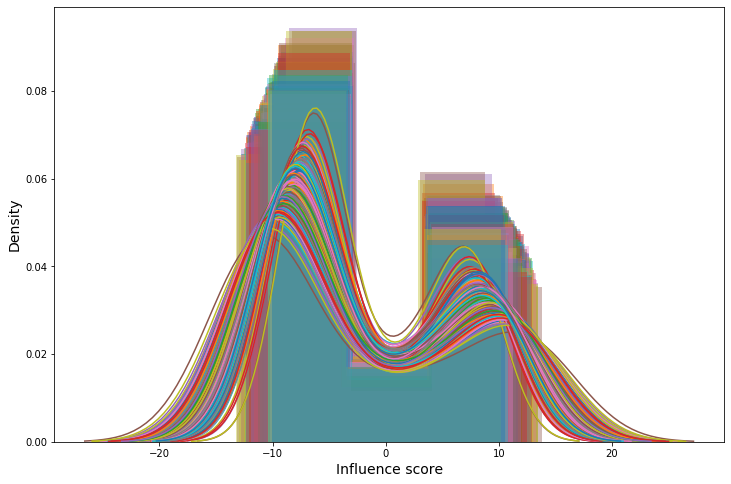

CPU times: user 14.6 s, sys: 176 ms, total: 14.8 s
Wall time: 14.8 s


In [27]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[:,i], ax=ax)
    if i == 500:
        break
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_yejin/train_influence_dist_all.png', bbox_inches='tight')
plt.show()

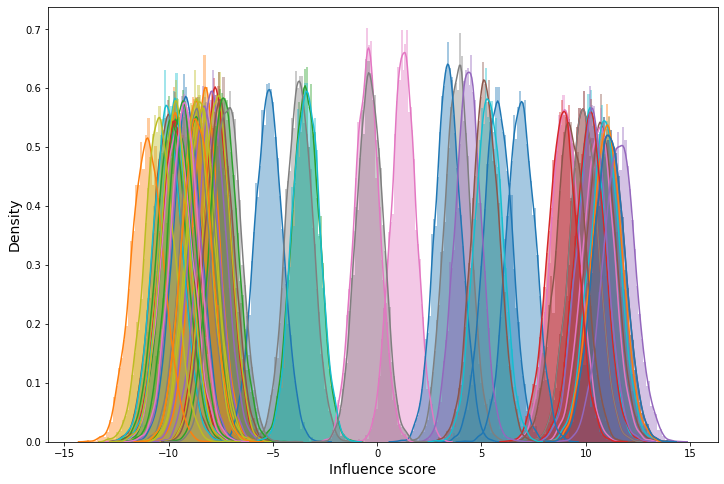

CPU times: user 13 s, sys: 64.7 ms, total: 13.1 s
Wall time: 13.1 s


In [28]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[0]):
    sns.distplot(influence_matrix[i,:], ax=ax)
    if i == 500:
        break
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_yejin/valid_influence_dist_all.png', bbox_inches='tight')
plt.show()

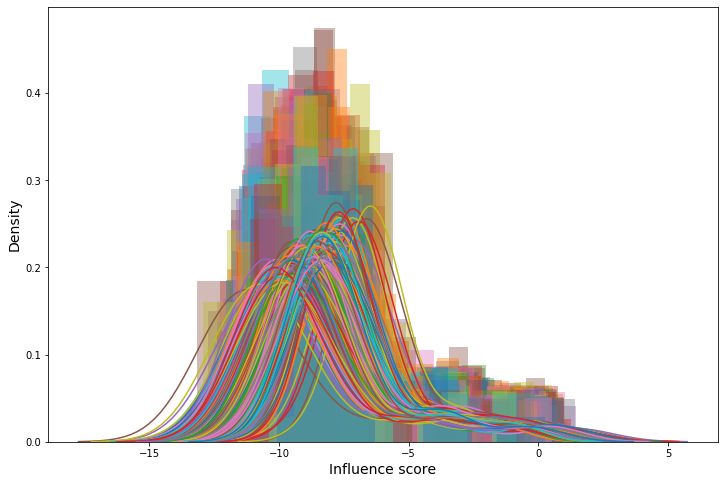

CPU times: user 27.6 s, sys: 225 ms, total: 27.8 s
Wall time: 27.8 s


In [34]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in range(influence_matrix.shape[1]):
    sns.distplot(influence_matrix[list(map(lambda x: id2idx[x], incorrect_list)),i], ax=ax)
    if i == 500:
        break
# plt.title('Distributuion of influence per training sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_yejin/incorrect_train_influence_dist_all.png', bbox_inches='tight')
plt.show()

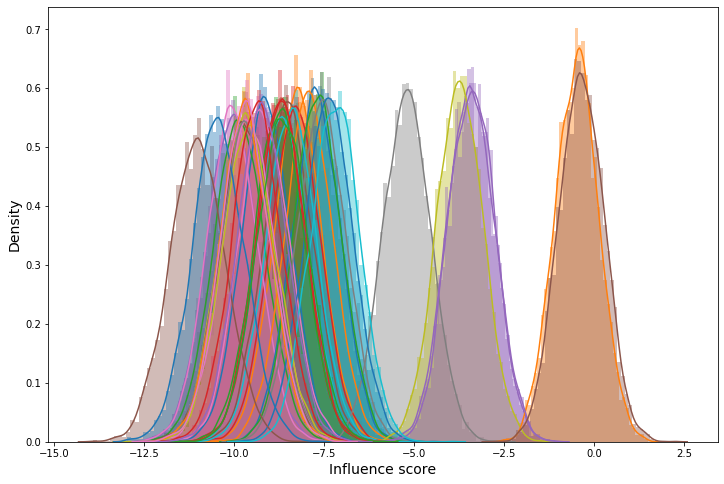

CPU times: user 8.39 s, sys: 64.1 ms, total: 8.45 s
Wall time: 8.44 s


In [35]:
%%time
plt.figure(figsize=(12,8))
ax = plt.gca()
for i in list(map(lambda x: id2idx[x], incorrect_list)):
    sns.distplot(influence_matrix[i,:], ax=ax)
# plt.title('Distributuion of influence per validation sample')
plt.xlabel('Influence score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.savefig('./tmp_yejin/incorrect_valid_influence_dist_all.png', bbox_inches='tight')
plt.show()

# Data cleansing

In [12]:
influence_matrix = np.load('./tmp_yejin/influence_matrix_all.npy', allow_pickle=True)

In [13]:
values, indices = torch.FloatTensor(influence_matrix.sum(axis=0)).sort()
values, indices = values.numpy, indices.numpy()

In [14]:
n_elmt = indices.shape[0]
percentages = np.arange(0, 1, 0.01) + 0.01
index_percent_list = {f'{np.round(p, 2):.2f}' : list(map(lambda x: str(x+1), indices[:int(n_elmt / (1 / p))])) for p in percentages}

In [15]:
pickle.dump(index_percent_list, open('./tmp_yejin/index_percent_list_all.pkl','wb'))